In [1]:
import os
import numpy as np
import cv2, pydicom
import matplotlib.pyplot as plt

In [41]:
class Dicom():
    def __init__(self, dicom_path=None, window_center=None, window_width=None, auto=None, percent=2):
        self.dicom_path = dicom_path
        self.window_center = window_center
        self.window_width = window_width
        self.auto = auto
        
        self.hu_img = self.dicom_to_array(self.dicom_path)

        self.hist, self.bins = np.histogram(self.hu_img.flatten(), \
            int(np.max(self.hu_img) - np.min(self.hu_img) + 1), [np.min(self.hu_img), np.max(self.hu_img) + 1])
        self.cdf = self.hist.cumsum()
        self.percent = percent
        if auto == "all":
            if self.cdf[0] < self.cdf[-1] * percent/100:
                clip_min = np.min(self.hu_img) + np.where(self.cdf < self.cdf[-1] * percent/100)[0][-1]
            else:
                clip_min = np.min(self.hu_img)
            if self.cdf[-1] > self.cdf[-1] * (100-percent)/100:
                clip_max = np.min(self.hu_img) + np.where(self.cdf > self.cdf[-1] * (100-percent)/100)[0][0]
            else:
                clip_max = np.max(self.hu_img)

            self.window_center = (clip_max + clip_min) / 2
            self.window_width = (clip_max - clip_min)

        if self.window_center is not None and self.window_width is not None:
            self.img = self.dicom_windowing(self.hu_img, self.window_center, self.window_width)
        else:
            self.img = self.hu_img

    def dicom_to_array(self, dicom_path):
        self.slice = pydicom.read_file(dicom_path)
        s = int(self.slice.RescaleSlope)
        b = int(self.slice.RescaleIntercept)
        return s * self.slice.pixel_array + b

    def get_min_max_window(self, hu_img):
        img_min = np.min(hu_img)
        img_max = np.max(hu_img)
        window_center = (img_max + img_min) / 2
        window_width = img_max - img_min
        return window_center, window_width

    def dicom_windowing(self, image, window_center, window_width):
        img_min = window_center - window_width / 2
        img_max = window_center + window_width / 2
        window_img = np.clip(image, img_min, img_max)
        return window_img
    
    def get_image(self):
        return self.img
    
    def get_hu_image(self):
        return self.hu_img
    
    def change_window(self, window_center, window_width):
        self.window_center = window_center
        self.window_width = window_width
        self.img = self.dicom_windowing(self.hu_img, self.window_center, self.window_width)
    
    def window_option(self, option):
        # (window center, width)
        options = {'brain' : (40, 80), 'soft tissues' : (40, 400), 'bone' : (400, 1800)}
        if option in options:
            self.window_center, self.window_width = options[option]
            self.change_window(self.window_center, self.window_width)
        else:
            print(f"input option : {option}, plz input right option")


In [3]:
data_list = os.listdir('data/Sample2')
dicom_path = os.path.join('data/Sample2',data_list[255])
dicom_file = Dicom(dicom_path=dicom_path, auto="all")
image = dicom_file.get_image()
hu_img = dicom_file.get_hu_image()

In [4]:
print(data_list[255])

2916.57736.31797.19482.39484.40487.59978.50158.100.328.dcm


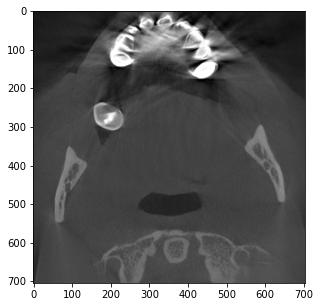

In [5]:
plt.figure(figsize=(10,5))
plt.imshow(hu_img, cmap='gray')

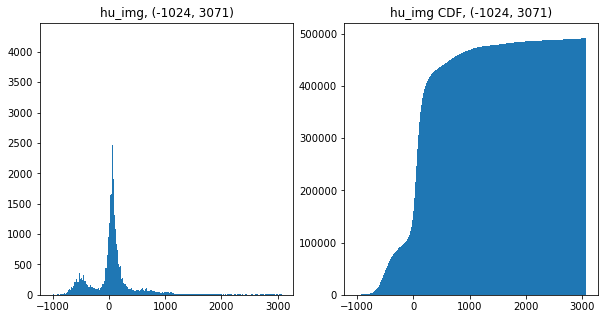

In [6]:
hist, bins = np.histogram(hu_img.flatten(), int(np.max(hu_img) - np.min(hu_img) + 1), [np.min(hu_img), np.max(hu_img) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(hu_img.flatten(), bins)
plt.title(f"hu_img, {np.min(hu_img), np.max(hu_img)}")
plt.subplot(1, 2, 2)
plt.hist(hu_img.flatten(), bins, cumulative=True)
plt.title(f"hu_img CDF, {np.min(hu_img), np.max(hu_img)}")
plt.show()

Text(0.5, 1.0, 'Window Center : 714.0, Window Width : 2744')

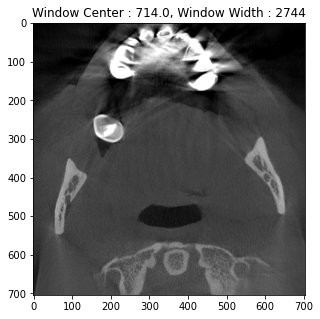

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(image, cmap="gray")
plt.title(f"Window Center : {dicom_file.window_center}, Window Width : {dicom_file.window_width}")

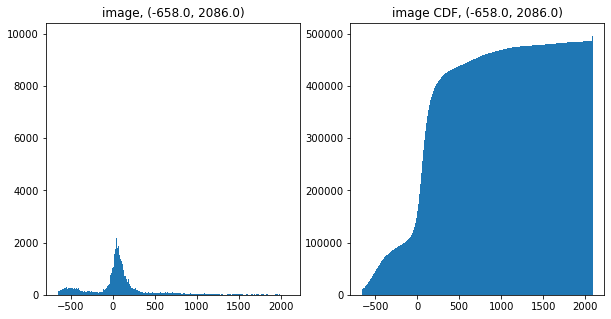

In [8]:
hist1, bins1 = np.histogram(image.flatten(), int(np.max(image) - np.min(image) + 1), [np.min(image), np.max(image) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(image.flatten(), bins1)
plt.title(f"image, {np.min(image), np.max(image)}")
plt.subplot(1, 2, 2)
plt.hist(image.flatten(), bins1, cumulative=True)
plt.title(f"image CDF, {np.min(image), np.max(image)}")
plt.show()

Text(0.5, 1.0, 'Window Center : 1066, Window Width : 2926')

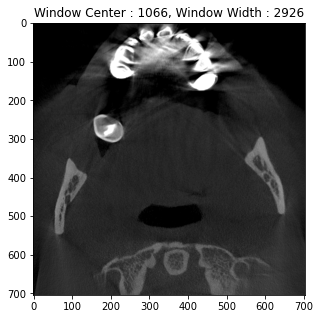

In [9]:
dicom_file.change_window(1066, 2926)
plt.figure(figsize=(10,5))
plt.imshow(dicom_file.img, cmap="gray")
plt.title(f"Window Center : {dicom_file.window_center}, Window Width : {dicom_file.window_width}")

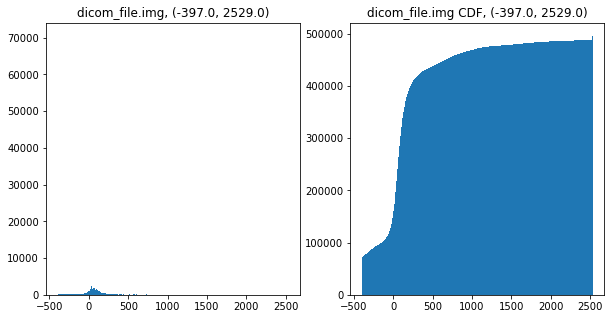

In [10]:
hist2, bins2 = np.histogram(dicom_file.img.flatten(), int(np.max(dicom_file.img) - np.min(dicom_file.img) + 1), [np.min(dicom_file.img), np.max(dicom_file.img) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(dicom_file.img.flatten(), bins2)
plt.title(f"dicom_file.img, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.subplot(1, 2, 2)
plt.hist(dicom_file.img.flatten(), bins2, cumulative=True)
plt.title(f"dicom_file.img CDF, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.show()

In [33]:
def select_roi(img):
    x, y, w, h = cv2.selectROI('img', img, False)
    if w and h:
        print(f'x:{x: 3d}, y:{y: 3d}, w:{w: 3d}, h:{h: 3d}')
        roi = img[y:y+h, x:x+w]
        cv2.imshow('roi', roi)
        cv2.moveWindow('roi', 0,0)
        # cv2.imwrite(save_path,roi)

    cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return x, y, w, h

In [12]:
float_hu_img = (hu_img - np.min(hu_img)) / (np.max(hu_img) - np.min(hu_img))

In [13]:
float_hu_img = np.expand_dims(float_hu_img, axis=2)

In [14]:
float_hu_img.shape

(704, 704, 1)

In [15]:
cv2.imshow('test', float_hu_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [34]:
x, y, w, h = select_roi(float_hu_img)

x: 141, y:  0, w: 410, h: 318


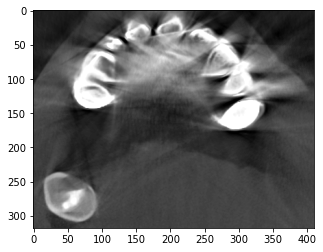

In [35]:
roi_img = hu_img[y:y+h, x:x+w]
plt.imshow(roi_img, cmap='gray')

In [36]:
np.max(roi_img), np.min(roi_img)

(3071, -1024)

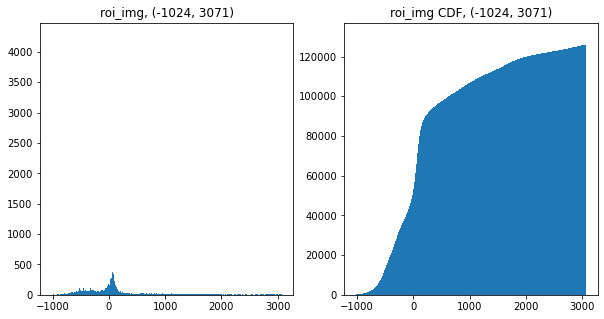

In [37]:
hist3, bins3 = np.histogram(roi_img.flatten(), int(np.max(roi_img) - np.min(roi_img) + 1), [np.min(roi_img), np.max(roi_img) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(roi_img.flatten(), bins3)
plt.title(f"roi_img, {np.min(roi_img), np.max(roi_img)}")
plt.subplot(1, 2, 2)
plt.hist(roi_img.flatten(), bins3, cumulative=True)
plt.title(f"roi_img CDF, {np.min(roi_img), np.max(roi_img)}")
plt.show()

Text(0.5, 1.0, 'Window Center : 1055.0, Window Width : 3320')

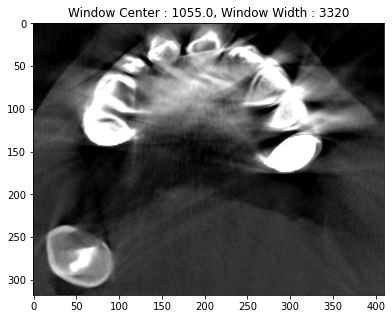

In [43]:
cdf = hist3.cumsum()

percent = 5

if cdf[0] < cdf[-1] * percent / 100:
    clip_min = np.min(hu_img) + np.where(cdf < cdf[-1] * percent / 100)[0][-1]
else:
    clip_min = np.min(hu_img)
if cdf[-1] > cdf[-1] * (100-percent)/100:
    clip_max = np.min(hu_img) + np.where(cdf > cdf[-1] * (100-percent)/100)[0][0]
else:
    clip_max = np.max(hu_img)

window_center = (clip_max + clip_min) / 2
window_width = (clip_max - clip_min)

window_img = np.clip(roi_img, clip_min, clip_max)

plt.figure(figsize=(10,5))
plt.imshow(window_img, cmap="gray")
plt.title(f"Window Center : {window_center}, Window Width : {window_width}")